In [10]:
import numpy as np
import pandas as pd
import json
from epilepsypcm.utils.outcome_params import node_location, early_propogation, irritative_zone

import warnings
warnings.filterwarnings('ignore')

from epilepsypcm.utils.make_df import make_df, get_df_list, concat_dfs
from epilepsypcm.models.base_models import *
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

all_positive_patients = pd.read_csv("df_final.csv", sep = ',').reset_index(drop = True)
print(all_positive_patients["outcome"].value_counts())


0.0    259
1.0     56
Name: outcome, dtype: int64


In [2]:
all_positive_patients["N1RespAvg"] = abs(all_positive_patients["N1RespAvg"])
all_positive_patients["N1StimAvg"] = abs(all_positive_patients["N1StimAvg"])

all_positive_patients["N2RespAvg"] = abs(all_positive_patients["N2RespAvg"])
all_positive_patients["N2StimAvg"] = abs(all_positive_patients["N2StimAvg"])
    
all_positive_patients["P2RespAvg"] = abs(all_positive_patients["P2RespAvg"])
all_positive_patients["P2StimAvg"] = abs(all_positive_patients["P2StimAvg"])
    

patient_list = all_positive_patients[all_positive_patients["outcome"] == 1.0]["patient"].value_counts().index

auc_list = []
acc_list = []
sens_list = []
spec_list = []
percent_ones = []

for patient in patient_list:
        
    sub_train_df = all_positive_patients[all_positive_patients.patient != patient]
    sub_test_df = all_positive_patients[all_positive_patients.patient == patient]
    
    max_depth = 20
    X_train = sub_train_df.drop(columns = ["Channels","outcome", "patient", "IZ", "EP"])
    y_train = sub_train_df[["outcome"]]["outcome"]
    X_test = sub_test_df.drop(columns = ["Channels", "outcome", "patient", "IZ", "EP"])
    y_test = sub_test_df[["outcome"]]["outcome"]

    
    rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
    y_pred = rf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    auc_list.append(metrics.auc(fpr, tpr))
    
    optimal_thresh = thresholds[np.argmax(tpr - fpr)]
    y_rounded = np.where(y_pred > optimal_thresh, 1, 0)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_rounded).ravel()

    acc_list.append((tp + tn)/(tp + fp + tn + fn))
    sens_list.append(tp / (tp + fn))
    spec_list.append(tn / (tn + fp))
    
    percent_ones.append(np.count_nonzero(y_rounded == 1)/len(y_pred))

    

In [3]:
density_pos = all_positive_patients[all_positive_patients["outcome"] == 1.0]["patient"].value_counts().index
density_all = all_positive_patients["patient"].value_counts()[density_pos]

Text(0.5, 1.0, 'Positive patients - density vs Specificity')

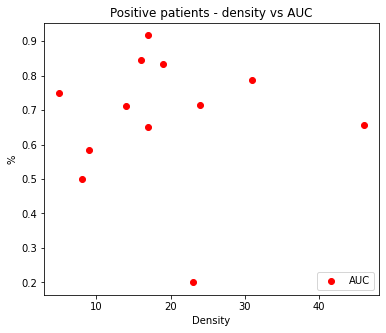

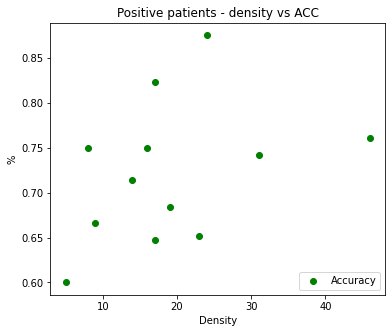

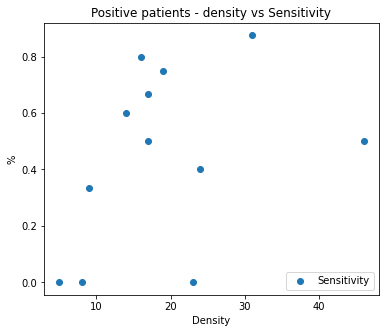

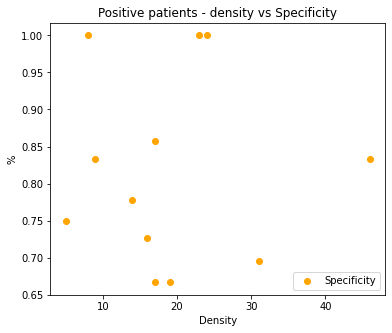

In [4]:
plt.figure(figsize = (6,5))
plt.scatter(density_all, auc_list, color = "red", label = "AUC")
plt.legend(loc="lower right")
plt.legend(loc="lower right")
plt.xlabel("Density")
plt.ylabel("%")
plt.title("Positive patients - density vs AUC")

plt.figure(figsize = (6,5))
plt.scatter(density_all, acc_list, color = "green", label = "Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Density")
plt.ylabel("%")
plt.title("Positive patients - density vs ACC")


plt.figure(figsize = (6,5))
plt.scatter(density_all, sens_list, label = "Sensitivity")
plt.legend(loc="lower right")
plt.legend(loc="lower right")
plt.xlabel("Density")
plt.ylabel("%")
plt.title("Positive patients - density vs Sensitivity")

plt.figure(figsize = (6,5))
plt.scatter(density_all, spec_list, color = "orange", label = "Specificity")
plt.legend(loc="lower right")
plt.xlabel("Density")
plt.ylabel("%")
plt.title("Positive patients - density vs Specificity")

Text(0.5, 1.0, 'Positive patients - density vs % 1s predicted')

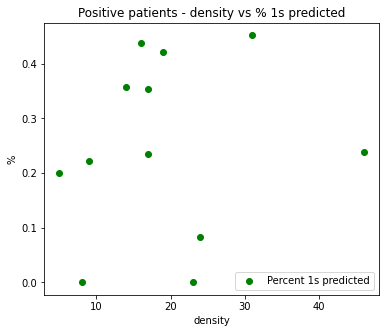

In [5]:
plt.figure(figsize = (6,5))
plt.scatter(density_all, percent_ones, color = "green", label = "Percent 1s predicted")
plt.legend(loc="lower right")
plt.xlabel("density")
plt.ylabel("%")
plt.title("Positive patients - density vs % 1s predicted")

In [6]:
all_neg_patients = pd.read_csv("unsuccessful_DF.csv", sep = ',', index_col = 0)
all_neg_patients.head()

,Channels,SigResp,SigStim,N1RespAvg,N1RespSDV,N2RespAvg,N2RespSDV,P2RespAvg,P2RespSDV,N1StimAvg,N1StimSDV,N2StimAvg,N2StimSDV,P2StimAvg,P2StimSDV,patient,InDegree,OutDegree,EV,Closeness
0,RA7_RA8,0.470588,0.235294,11.275250,13.430507,12.300852,17.797695,10.693199,13.013718,5.385827,5.037416,8.653968,8.250072,6.505716,4.873793,PY21N007,0.444444,0.222222,1.839785e-01,0.600000
1,RA8_RA9,0.411765,0.294118,11.349622,14.409670,15.607462,22.626955,9.325437,7.232690,5.110791,4.167502,5.253412,4.484553,5.456525,4.048721,PY21N007,0.388889,0.277778,1.687278e-01,0.580645
2,RH1_RH2,0.166667,0.277778,18.722890,47.849258,9.351465,17.359378,7.040116,16.182438,20.063484,41.903112,7.045011,12.544347,9.430739,13.200236,PY21N007,0.166667,0.277778,1.150292e-01,0.514286
3,RH5_RH6,0.777778,0.500000,17.155535,12.812753,6.383174,4.995149,11.223168,7.985343,13.980816,17.902728,18.496704,23.920131,9.152502,11.720191,PY21N007,0.777778,0.500000,3.212952e-01,0.818182
4,RHG1_RHG2,0.166667,0.666667,6.654436,13.721655,2.825886,2.155459,3.864567,6.131093,15.076088,10.356663,4.687854,4.377788,9.564763,8.984542,PY21N007,0.166667,0.666667,7.137374e-07,0.166667


In [7]:
patient_list = all_neg_patients["patient"].value_counts().index

one_count = 0
all_count = 0

percent_ones_neg = []

for patient in patient_list:
    
    sub_df = all_neg_patients[all_neg_patients.patient == patient]
    
    X_test = sub_df.drop(columns=["Channels", "patient"])
    outcome_pred = rf.predict_proba(X_test)[:, 1]
    outcome_pred_rounded = np.where(outcome_pred > optimal_thresh, 1, 0)
    
    df_output = pd.DataFrame()
    df_output["Channels"] = sub_df["Channels"]
    df_output["Predicted Outcome"] = outcome_pred_rounded
    df_output["Probability of Outcome"] = outcome_pred
    
    one_count = list(outcome_pred_rounded).count(1)
    all_count = len(outcome_pred_rounded)
    
    percent_ones_neg.append(one_count/all_count)


#print("% of 1s", (one_count/all_count))

In [8]:
density_all_neg = all_neg_patients["patient"].value_counts()

Text(0.5, 1.0, 'Pos + Neg patients - density vs % 1s predicted')

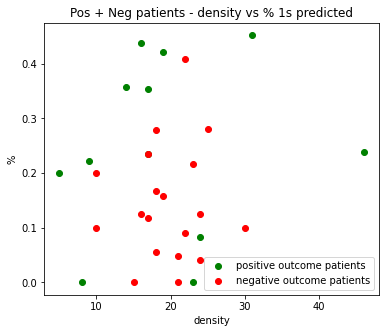

In [9]:
plt.figure(figsize = (6,5))
plt.scatter(density_all, percent_ones, color = "green", label = "positive outcome patients")
plt.legend(loc="lower right")
plt.xlabel("density")
plt.ylabel("%")

plt.scatter(density_all_neg, percent_ones_neg, color = "red", label = "negative outcome patients")
plt.legend(loc="lower right")
plt.xlabel("density")
plt.ylabel("%")
plt.title("Pos + Neg patients - density vs % 1s predicted")